残差网络ResNet vs LeNet 对比实验

本实验将对比以下模型:
1. LeNet - 基准CNN）
2. Lightweight ResNet - 残差网络

实验配置:
- 训练轮数: 10 epochs
- 优化器: SGD (lr=0.001, momentum=0.9)
- 正则化: L2 (weight_decay=0.01) + Dropout (0.5)
- 批次大小: 64

开始实验...

加载CIFAR-10数据集...
Files already downloaded and verified
Files already downloaded and verified

模型架构对比
LeNet (benchmark)         - 参数量: 62,006
Lightweight ResNet        - 参数量: 309,322

开始训练: LeNet (benchmark)
Epoch 1/10 - Loss: 2.300, Test Acc: 15.01%
Epoch 2/10 - Loss: 2.250, Test Acc: 17.37%
Epoch 3/10 - Loss: 2.146, Test Acc: 23.06%
Epoch 4/10 - Loss: 2.094, Test Acc: 24.39%
Epoch 5/10 - Loss: 2.052, Test Acc: 26.56%
Epoch 6/10 - Loss: 2.008, Test Acc: 28.51%
Epoch 7/10 - Loss: 1.934, Test Acc: 31.21%
Epoch 8/10 - Loss: 1.857, Test Acc: 32.69%
Epoch 9/10 - Loss: 1.807, Test Acc: 34.06%
Epoch 10/10 - Loss: 1.768, Test Acc: 36.30%

训练完成! 总用时: 49.1秒
最终测试准确率: 36.30%
模型已保存: ./task4_comparison/LeNet_(benchmark).pth


开始训练: Lightweight ResNet
Epoch 1/10 - Loss: 1.816, Test Acc: 44.6

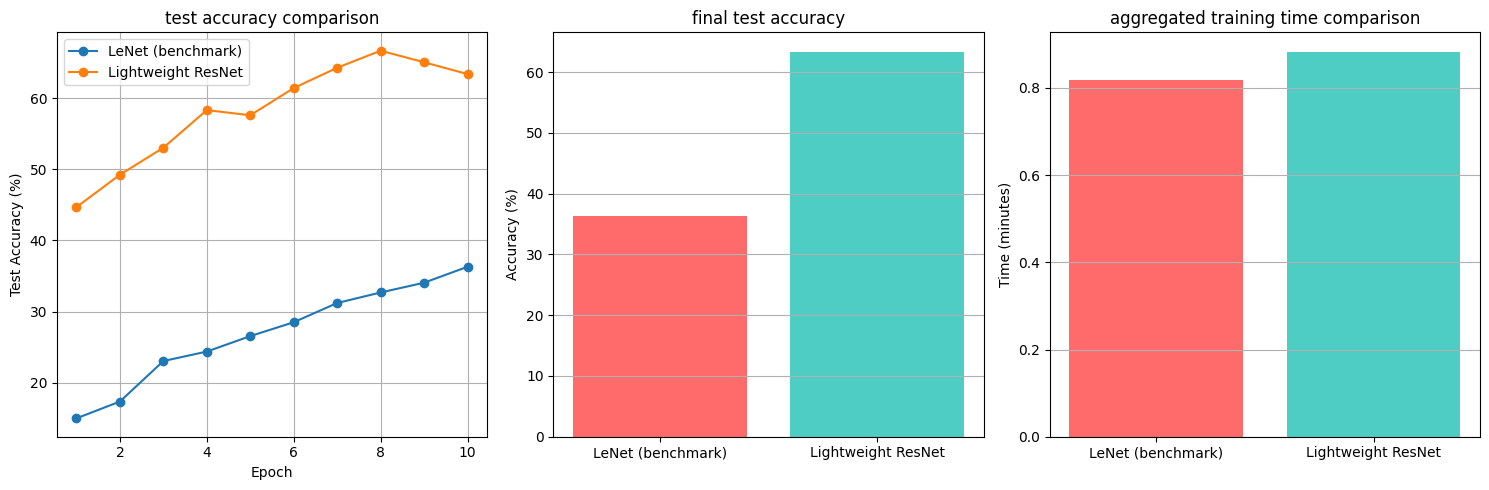


模型对比报告
模型名称                      最终准确率           总训练时间          
------------------------------------------------------------
LeNet (benchmark)                 36.30%           0.8min
Lightweight ResNet                63.37%           0.9min

实验完成！所有结果已保存在 './task4_comparison' 目录下


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
import os
import time

# 确定GPU运行
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ============================================================================
# 1. 原始LeNet（基准模型）
# ============================================================================
class LeNet(nn.Module):
    """
    原始LeNet架构（基准模型）
    - 2个卷积层
    - 3个全连接层
    - 使用ReLU激活和Dropout
    """
    def __init__(self, dropout_rate=0.5):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ============================================================================
# 2. 轻量级ResNet（简化版）
# ============================================================================
class ResidualBlock(nn.Module):
    """简化残差块"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 如果输入输出维度不同，需要调整shortcut
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)  # 残差连接
        out = F.relu(out)
        return out

class LightweightResNet(nn.Module):
    """
    轻量级ResNet
    改进点：
    - 残差连接（解决梯度消失问题）
    - Batch Normalization
    - 减少通道数和块数以节省算力
    """
    def __init__(self, dropout_rate=0.5):
        super(LightweightResNet, self).__init__()
        
        # 初始卷积层（减少通道）
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # 残差块组（简化：每个层1个块，减少通道）
        self.layer1 = ResidualBlock(32, 32, stride=1)
        self.layer2 = ResidualBlock(32, 64, stride=2)
        self.layer3 = ResidualBlock(64, 128, stride=2)
        
        # 全局平均池化和全连接层
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# ============================================================================
# 3. 训练和评估函数
# ============================================================================
def train_model(model, trainloader, testloader, num_epochs, criterion,
                optimizer, model_name, save_path):
    """
    训练模型并记录性能指标
    """
    os.makedirs(save_path, exist_ok=True)
    
    history = {
        'train_losses': [],
        'test_accuracies': [],
        'total_time': 0.0,
        'model_name': model_name
    }
    
    print(f"\n{'='*50}")
    print(f"开始训练: {model_name}")
    print(f"{'='*50}")
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        running_loss = 0.0
        num_batches = 0
        
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = running_loss / num_batches
        history['train_losses'].append(avg_train_loss)
        
        # 测试阶段
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_acc = 100 * correct / total
        history['test_accuracies'].append(test_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.3f}, Test Acc: {test_acc:.2f}%')
    
    history['total_time'] = time.time() - start_time
    
    print(f"\n训练完成! 总用时: {history['total_time']:.1f}秒")
    print(f"最终测试准确率: {history['test_accuracies'][-1]:.2f}%")
    
    return history

def count_parameters(model):
    """统计模型参数量"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ============================================================================
# 4. 对比实验主程序
# ============================================================================
def run_comparison_experiments():
    """运行对比实验"""
    
    # 数据加载
    print("加载CIFAR-10数据集...")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    trainset = torchvision.datasets.CIFAR10(root='./dataset', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                              shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR10(root='./dataset', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                             shuffle=False, num_workers=2)
    
    # 定义要对比的模型
    models = {
        'LeNet (benchmark)': LeNet(dropout_rate=0.5),
        'Lightweight ResNet': LightweightResNet(dropout_rate=0.5)
    }
    
    # 训练参数
    num_epochs = 10
    criterion = nn.CrossEntropyLoss()
    
    # 存储实验结果
    all_histories = {}
    
    # 打印模型信息
    print("\n" + "="*50)
    print("模型架构对比")
    print("="*50)
    for name, model in models.items():
        params = count_parameters(model)
        print(f"{name:25s} - 参数量: {params:,}")
    print("="*50)
    
    # 训练每个模型
    for name, model in models.items():
        model = model.to(device)#确保GPU
        optimizer = optim.SGD(model.parameters(), lr=0.001,
                              momentum=0.9, weight_decay=0.01)
        
        history = train_model(
            model=model,
            trainloader=trainloader,
            testloader=testloader,
            num_epochs=num_epochs,
            criterion=criterion,
            optimizer=optimizer,
            model_name=name,
            save_path='./task4_comparison'
        )
        
        all_histories[name] = history
        
        # 保存模型
        model_path = f'./task4_comparison/{name.replace(" ", "_")}.pth'
        torch.save(model.state_dict(), model_path)
        print(f"模型已保存: {model_path}\n")
    
    return all_histories

# ============================================================================
# 5. 结果可视化
# ============================================================================
def visualize_comparison(all_histories, save_path='./task4_comparison'):
    """可视化对比结果"""
    os.makedirs(save_path, exist_ok=True)
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # 子图1: 测试准确率对比
    for name, history in all_histories.items():
        epochs = range(1, len(history['test_accuracies']) + 1)
        axs[0].plot(epochs, history['test_accuracies'], marker='o', label=name)
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Test Accuracy (%)')
    axs[0].set_title('test accuracy comparison')
    axs[0].legend()
    axs[0].grid(True)
    
    # 子图2: 最终准确率柱状图
    names = list(all_histories.keys())
    final_accs = [h['test_accuracies'][-1] for h in all_histories.values()]
    colors = ['#FF6B6B', '#4ECDC4']
    axs[1].bar(names, final_accs, color=colors)
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].set_title('final test accuracy')
    axs[1].grid(True, axis='y')
    
    # 子图3: 训练时间对比
    total_times = [h['total_time']/60 for h in all_histories.values()]  # 转换为分钟
    axs[2].bar(names, total_times, color=colors)
    axs[2].set_ylabel('Time (minutes)')
    axs[2].set_title('aggregated training time comparison')
    axs[2].grid(True, axis='y')
    
    plt.tight_layout()
    plot_path = os.path.join(save_path, 'model_comparison.png')
    plt.savefig(plot_path, dpi=300)
    print(f'\n对比图已保存至: {plot_path}')
    plt.show()
    
    # 生成简要报告
    print("\n" + "="*60)
    print("模型对比报告")
    print("="*60)
    print(f"{'模型名称':<25} {'最终准确率':<15} {'总训练时间':<15}")
    print("-"*60)
    
    for name, history in all_histories.items():
        final_acc = history['test_accuracies'][-1]
        total_time = history['total_time']
        print(f"{name:<25} {final_acc:>13.2f}% {total_time/60:>13.1f}min")
    
    print("="*60)

# ============================================================================
# 主程序
# ============================================================================
if __name__ == '__main__':
    print("="*50)
    print("残差网络ResNet vs LeNet 对比实验")
    print("="*50)
    print("\n本实验将对比以下模型:")
    print("1. LeNet - 基准CNN）")
    print("2. Lightweight ResNet - 残差网络")
    print("\n实验配置:")
    print("- 训练轮数: 10 epochs")
    print("- 优化器: SGD (lr=0.001, momentum=0.9)")
    print("- 正则化: L2 (weight_decay=0.01) + Dropout (0.5)")
    print("- 批次大小: 64")
    print("\n开始实验...\n")
    
    # 运行对比实验
    all_histories = run_comparison_experiments()
    
    # 可视化结果
    print("\n生成对比可视化...")
    visualize_comparison(all_histories)
    
    print("\n实验完成！所有结果已保存在 './task4_comparison' 目录下")